### The following analysis will be conducted on a Netflix movie database. During this study, we will analyze the variables of the database, describe the individuals and variables, and then perform a factor analysis (MCA and PCA) before conducting clustering.

# **Import libraries**

In [ ]:
# Libraries: Standard ones
import pandas as pd
import numpy as np

# Library for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.express as px

# K-means function
from sklearn.cluster import KMeans

# Functions for silhouette
from sklearn.metrics import silhouette_samples, silhouette_score

# Function to standardize the data
from sklearn.preprocessing import scale

# Functions for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

# **Data Preparation for vizualization**

### **Attribute information**
show_id : Unique ID for every Movie / Tv Show

type : Identifier - A Movie or TV Show

title : Title of the Movie / Tv Show

director : Director of the Movie

cast : Actors involved in the movie / show

country : Country where the movie / show was produced

date_added : Date it was added on Netflix

release_year : Actual Releaseyear of the movie / show

rating : TV Rating of the movie / show

duration : Total Duration - in minutes or number of seasons

listed_in : Genre

description: The Summary description

In [ ]:
# Load the data: netflix
netflix = pd.read_csv("netflix_titles.csv", sep= ",")
# print(netflix)
netflix.describe() # Statistical summary of the dat

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#see the variables and individuals as a table
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


As we can see, many columns contain strings information and we need to convert them in float (comptable information) in order to analyze them.

In [ ]:
#  Group the dataset by type and duration and count the frequency of each duration
netflix.groupby(["type", "duration"])["duration"].count()

type     duration 
Movie    10 min         1
         100 min      108
         101 min      116
         102 min      122
         103 min      114
                     ... 
TV Show  5 Seasons     65
         6 Seasons     33
         7 Seasons     23
         8 Seasons     17
         9 Seasons      9
Name: duration, Length: 220, dtype: int64

This code allows us to notice that there are 2 types of film and each type has a duration type e.i movies duration are in minutes and TV Show durations are in seasons. We might need to convert to the same unit if we do the anaylyze in the both type of films.

In [ ]:
# Check for duplicate records
netflix.duplicated().value_counts()
# There is no duplicate record in this dataset

False    8807
dtype: int64

In [ ]:
# Check for the null values
netflix.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [ ]:
# Fill-in the nan value to 'unknown' in the director, cast and country columns
netflix['country'].replace(np.nan, 'Unknown',inplace  = True)
netflix['director'].replace(np.nan, 'Unknown',inplace  = True)
netflix['cast'].replace(np.nan, 'Unknown',inplace  = True)

# Remove all the other null values
netflix = netflix[~((netflix['date_added'].isna()))]
netflix = netflix[~((netflix['rating'].isna()))]
netflix = netflix[~((netflix['duration'].isna()))]

# Check for the null values after filling and droping
netflix.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [ ]:
# Typecasting 'date_added' from string to datetime
netflix["date_added"] = pd.to_datetime(netflix['date_added'])

# add new features in the dataset
netflix['year_added'] = netflix['date_added'].dt.year
netflix['month_added'] = netflix['date_added'].dt.month

# first and last date on which a show was added on Netflix
netflix.date_added.min(),netflix.date_added.max()

netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021,9
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021,9
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021,9
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021,9
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021,9


In [ ]:
# Choosing the primary country to simplify the analysis
netflix['country'] = netflix['country'].apply(lambda x: x.split(',')[0])

In [ ]:
# Change the duration of movie from "object" to "int"
# Filter the DataFrame to get only movies
netflix_movie = netflix[netflix["type"] == "Movie"].copy()

# Change the duration of movie from "object" to "int"
netflix_movie["duration"] = netflix_movie['duration'].astype(str)
netflix_movie["duration"] = netflix_movie['duration'].str.extract('(\d+)').astype(float)

netflix_movie.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90.0,Documentaries,"As her father nears the end of his life, filmm...",2021,9
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",Unknown,2021-09-24,2021,PG,91.0,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...,2021,9
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...",United States,2021-09-24,1993,TV-MA,125.0,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s...",2021,9
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,2021-09-24,2021,PG-13,104.0,"Comedies, Dramas",A woman adjusting to life after a loss contend...,2021,9
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...",Germany,2021-09-23,2021,TV-MA,127.0,"Dramas, International Movies",After most of her family is murdered in a terr...,2021,9


In [ ]:
# Filter the DataFrame to get only TV show
netflix_tvshow = netflix[netflix["type"] == "TV Show"].copy()
# Extract only the number of season
netflix_tvshow['season_count'] = netflix_tvshow['duration'].str.extract('(\d+)').astype(int)
# Drop the duration column
netflix_tvshow.drop('duration', axis = 1, inplace=True)
netflix_tvshow.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,listed_in,description,year_added,month_added,season_count
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021,9,2
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021,9,1
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021,9,1
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021,9,2
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",Unknown,2021-09-24,2021,TV-MA,"TV Dramas, TV Horror, TV Mysteries",The arrival of a charismatic young priest brin...,2021,9,1


In [ ]:
# The ratings can be changed to age restrictions that apply on certain movies and TV shows.
# Age ratings
netflix.rating.unique()
# Changing the values in the rating column
rating_map = {'TV-MA':'Adults',
              'R':'Adults',
              'PG-13':'Teens',
              'TV-14':'Young Adults',
              'TV-PG':'Older Kids',
              'NR':'Adults',
              'TV-G':'Kids',
              'TV-Y':'Kids',
              'TV-Y7':'Older Kids',
              'PG':'Older Kids',
              'G':'Kids',
              'NC-17':'Adults',
              'TV-Y7-FV':'Older Kids',
              'UR':'Adults'}

netflix['rating'].replace(rating_map, inplace = True)
netflix['rating'].unique()

array(['Teens', 'Adults', 'Older Kids', 'Young Adults', 'Kids'],
      dtype=object)

# **Data visualization**

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Adults'),
  Text(1, 0, 'Young Adults'),
  Text(2, 0, 'Older Kids'),
  Text(3, 0, 'Kids'),
  Text(4, 0, 'Teens')])

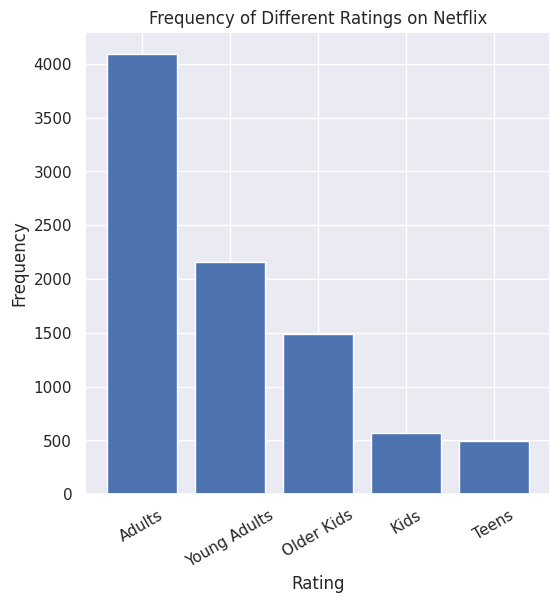

In [ ]:
# Compute the frequency of different ratings,Sort in descending order
rating_counts = netflix['rating'].value_counts()
rating_counts = rating_counts.sort_values(ascending=False)

plt.figure(figsize=(6, 6))
plt.bar(rating_counts.index, rating_counts.values)

plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Frequency of Different Ratings on Netflix")

plt.xticks(rotation=30)

Most of the content on Netflix are for adults.

([0, 1, 2, 3, 4],
 [Text(0, 0, 'United States'),
  Text(1, 0, 'India'),
  Text(2, 0, 'Unknown'),
  Text(3, 0, 'United Kingdom'),
  Text(4, 0, 'Canada')])

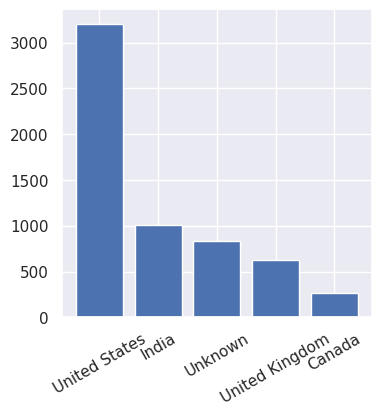

In [ ]:
# Compute the frequency of top five countries,Sort in descending order
country_counts = netflix['country'].value_counts().sort_values(ascending=False)
country_counts_top = country_counts.iloc[:5]

plt.figure(figsize=(4,4))
plt.bar(country_counts_top.index ,country_counts_top.values)
plt.xticks(rotation=30)

The most popular country where the content is filmed is United States, and follow by India.

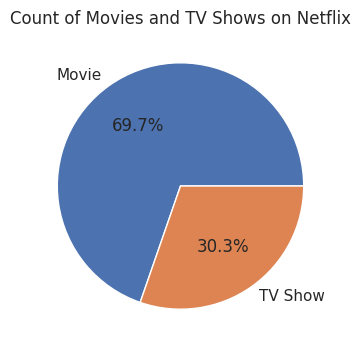

In [ ]:
# Count of Movies and TV Shows on Netflix
plt.figure(figsize=(4, 4))
plt.pie( netflix["type"].value_counts(),autopct='%1.1f%%', labels = netflix["type"].unique())
plt.title("Count of Movies and TV Shows on Netflix")
plt.show()

There are two types of content on Netflix which are Movies and TV show, in which, movies are the majority.

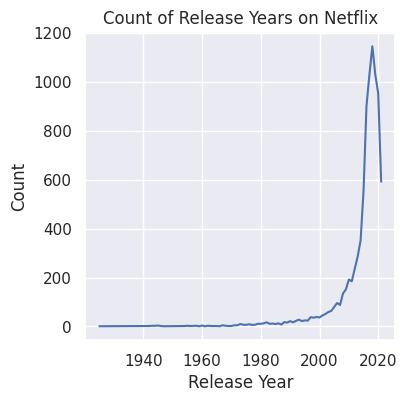

In [ ]:
# Count of Release Years on Netflix
plt.figure(figsize=(4,4))

yearly_counts = netflix['release_year'].value_counts().sort_index()
plt.plot(yearly_counts.index, yearly_counts.values, linestyle='-')

plt.title("Count of Release Years on Netflix")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.show()


From 2000 to 2019, the number of films released increased significantly, peaking in 2019 and decreasing sharply thereafter.

Text(0.5, 1.0, 'Distribution of Movie Durations on Netflix')

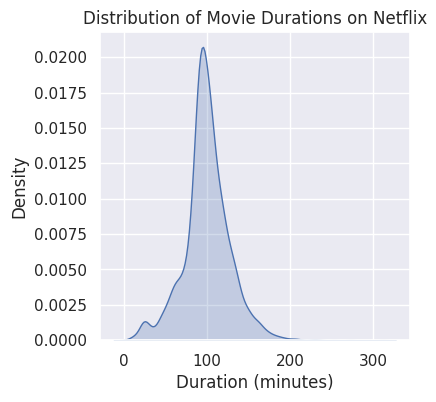

In [ ]:
# Create the KDE plot
plt.figure(figsize=(4,4))  # Adjust the figure size as needed
sns.set(style="darkgrid")
sns.kdeplot(data=netflix_movie["duration"], fill=True)

# Set labels and title
plt.xlabel("Duration (minutes)")
plt.ylabel("Density")
plt.title("Distribution of Movie Durations on Netflix")

The kernel density estimate (KDE) graph represents the data using a continuous probability density curve.
Most of movies on Netflix are among the duration of 80-110 minutes.

(0.0, 10.0)

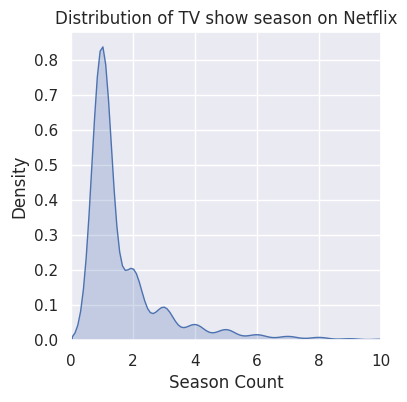

In [ ]:
# Create the KDE plot for TVShow
plt.figure(figsize=(4,4))  # Adjust the figure size as needed
sns.set(style="darkgrid")
sns.kdeplot(data=netflix_tvshow["season_count"], fill=True)

# Set labels and title
plt.xlabel("Season Count")
plt.ylabel("Density")
plt.title("Distribution of TV show season on Netflix")
plt.xlim(0,10)

TV shows on Netflix are among the duration of 1-6 seasons. Most of them only has 1-2 seasons.

In [ ]:
# Average duration and variance of duration of movies
movie_dur_mean = round(netflix_movie["duration"].mean(),1)
movie_dur_varaince = round(netflix_movie["duration"].var(),1)
print("Average duration of movie on Netflix",movie_dur_mean )
print("Variance of duration of movie on Netflix",movie_dur_varaince)

Average duration of movie on Netflix 99.6
Variance of duration of movie on Netflix 799.9


Text(0.5, 1.0, 'Average Movie Duration on Netflix Over the Years')

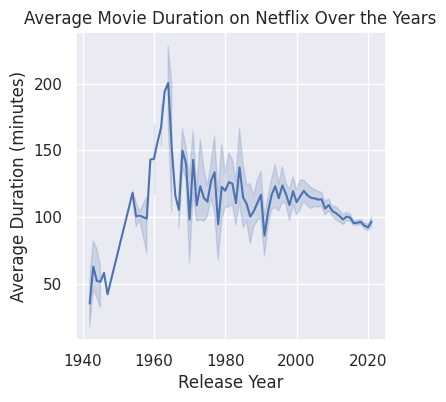

In [ ]:
# Movie duration change over the years on Netflix
plt.figure(figsize = (4,4))
sns.lineplot(x= netflix_movie["release_year"], y=netflix_movie["duration"])
plt.xlabel("Release Year")
plt.ylabel("Average Duration (minutes)")
plt.title("Average Movie Duration on Netflix Over the Years")

The movies released from 1940s to 1960s have increased in duration and reached a peak in 1960s (200 minutes), then decreased significantly.
Since 2000, movies have been getting shorter.

###World Cloud chart for genre of the contents




In [ ]:
from wordcloud import WordCloud

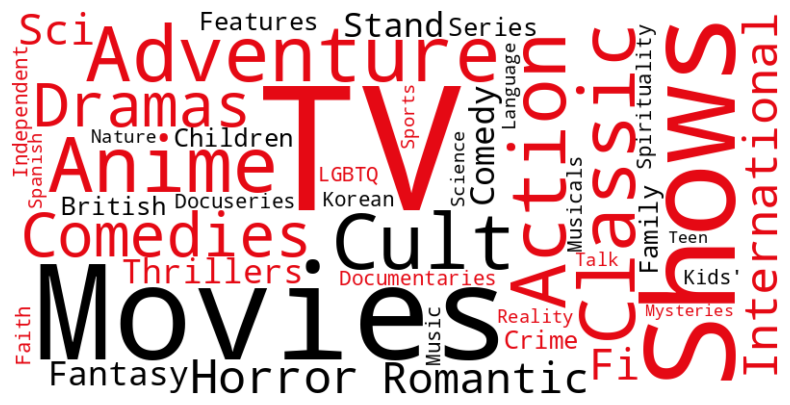

In [ ]:
# Define Netflix-like custom colors
netflix_colors = ['#E50914', '#000000']

# Join your categories as text (replace with your actual data)
categories = netflix['listed_in'].str.get_dummies(sep=', ')
categories = netflix_categories# Replace with your categories
category_text = ' '.join(categories)

# Create a custom colormap with your Netflix colors
custom_colormap = plt.cm.colors.ListedColormap(netflix_colors)

# Generate the WordCloud with the custom colormap
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap=custom_colormap,  # Use the custom colormap
    contour_color='black',
).generate(category_text)

# Create a plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.show()

According to this graph that, in the Netflix movies database, there is a lot of Adventure, comedies, action, horror, anime, classic and international films (Tv shows and movies).

###World map for countries

In [ ]:
# Create a dictionary with the country name as keys and country code as values
country_codes = {'afghanistan': 'AFG',
 'albania': 'ALB',
 'algeria': 'DZA',
 'american samoa': 'ASM',
 'andorra': 'AND',
 'angola': 'AGO',
 'anguilla': 'AIA',
 'antigua and barbuda': 'ATG',
 'argentina': 'ARG',
 'armenia': 'ARM',
 'aruba': 'ABW',
 'australia': 'AUS',
 'austria': 'AUT',
 'azerbaijan': 'AZE',
 'bahamas': 'BHM',
 'bahrain': 'BHR',
 'bangladesh': 'BGD',
 'barbados': 'BRB',
 'belarus': 'BLR',
 'belgium': 'BEL',
 'belize': 'BLZ',
 'benin': 'BEN',
 'bermuda': 'BMU',
 'bhutan': 'BTN',
 'bolivia': 'BOL',
 'bosnia and herzegovina': 'BIH',
 'botswana': 'BWA',
 'brazil': 'BRA',
 'british virgin islands': 'VGB',
 'brunei': 'BRN',
 'bulgaria': 'BGR',
 'burkina faso': 'BFA',
 'burma': 'MMR',
 'burundi': 'BDI',
 'cabo verde': 'CPV',
 'cambodia': 'KHM',
 'cameroon': 'CMR',
 'canada': 'CAN',
 'cayman islands': 'CYM',
 'central african republic': 'CAF',
 'chad': 'TCD',
 'chile': 'CHL',
 'china': 'CHN',
 'colombia': 'COL',
 'comoros': 'COM',
 'congo democratic': 'COD',
 'Congo republic': 'COG',
 'cook islands': 'COK',
 'costa rica': 'CRI',
 "cote d'ivoire": 'CIV',
 'croatia': 'HRV',
 'cuba': 'CUB',
 'curacao': 'CUW',
 'cyprus': 'CYP',
 'czech republic': 'CZE',
 'denmark': 'DNK',
 'djibouti': 'DJI',
 'dominica': 'DMA',
 'dominican republic': 'DOM',
 'ecuador': 'ECU',
 'egypt': 'EGY',
 'el salvador': 'SLV',
 'equatorial guinea': 'GNQ',
 'eritrea': 'ERI',
 'estonia': 'EST',
 'ethiopia': 'ETH',
 'falkland islands': 'FLK',
 'faroe islands': 'FRO',
 'fiji': 'FJI',
 'finland': 'FIN',
 'france': 'FRA',
 'french polynesia': 'PYF',
 'gabon': 'GAB',
 'gambia, the': 'GMB',
 'georgia': 'GEO',
 'germany': 'DEU',
 'ghana': 'GHA',
 'gibraltar': 'GIB',
 'greece': 'GRC',
 'greenland': 'GRL',
 'grenada': 'GRD',
 'guam': 'GUM',
 'guatemala': 'GTM',
 'guernsey': 'GGY',
 'guinea-bissau': 'GNB',
 'guinea': 'GIN',
 'guyana': 'GUY',
 'haiti': 'HTI',
 'honduras': 'HND',
 'hong kong': 'HKG',
 'hungary': 'HUN',
 'iceland': 'ISL',
 'india': 'IND',
 'indonesia': 'IDN',
 'iran': 'IRN',
 'iraq': 'IRQ',
 'ireland': 'IRL',
 'isle of man': 'IMN',
 'israel': 'ISR',
 'italy': 'ITA',
 'jamaica': 'JAM',
 'japan': 'JPN',
 'jersey': 'JEY',
 'jordan': 'JOR',
 'kazakhstan': 'KAZ',
 'kenya': 'KEN',
 'kiribati': 'KIR',
 'north korea': 'PRK',
 'south korea': 'KOR',
 'kosovo': 'KSV',
 'kuwait': 'KWT',
 'kyrgyzstan': 'KGZ',
 'laos': 'LAO',
 'latvia': 'LVA',
 'lebanon': 'LBN',
 'lesotho': 'LSO',
 'liberia': 'LBR',
 'libya': 'LBY',
 'liechtenstein': 'LIE',
 'lithuania': 'LTU',
 'luxembourg': 'LUX',
 'macau': 'MAC',
 'macedonia': 'MKD',
 'madagascar': 'MDG',
 'malawi': 'MWI',
 'malaysia': 'MYS',
 'maldives': 'MDV',
 'mali': 'MLI',
 'malta': 'MLT',
 'marshall islands': 'MHL',
 'mauritania': 'MRT',
 'mauritius': 'MUS',
 'mexico': 'MEX',
 'micronesia': 'FSM',
 'moldova': 'MDA',
 'monaco': 'MCO',
 'mongolia': 'MNG',
 'montenegro': 'MNE',
 'morocco': 'MAR',
 'mozambique': 'MOZ',
 'namibia': 'NAM',
 'nepal': 'NPL',
 'netherlands': 'NLD',
 'new caledonia': 'NCL',
 'new zealand': 'NZL',
 'nicaragua': 'NIC',
 'nigeria': 'NGA',
 'niger': 'NER',
 'niue': 'NIU',
 'northern mariana islands': 'MNP',
 'norway': 'NOR',
 'oman': 'OMN',
 'pakistan': 'PAK',
 'palau': 'PLW',
 'panama': 'PAN',
 'papua new guinea': 'PNG',
 'paraguay': 'PRY',
 'peru': 'PER',
 'philippines': 'PHL',
 'poland': 'POL',
 'portugal': 'PRT',
 'puerto rico': 'PRI',
 'qatar': 'QAT',
 'romania': 'ROU',
 'russia': 'RUS',
 'rwanda': 'RWA',
 'saint kitts and nevis': 'KNA',
 'saint lucia': 'LCA',
 'saint martin': 'MAF',
 'saint pierre and miquelon': 'SPM',
 'saint vincent and the grenadines': 'VCT',
 'samoa': 'WSM',
 'san marino': 'SMR',
 'sao tome and principe': 'STP',
 'saudi arabia': 'SAU',
 'senegal': 'SEN',
 'serbia': 'SRB',
 'seychelles': 'SYC',
 'sierra leone': 'SLE',
 'singapore': 'SGP',
 'sint maarten': 'SXM',
 'slovakia': 'SVK',
 'slovenia': 'SVN',
 'solomon islands': 'SLB',
 'somalia': 'SOM',
 'south africa': 'ZAF',
 'south sudan': 'SSD',
 'spain': 'ESP',
 'sri lanka': 'LKA',
 'sudan': 'SDN',
 'suriname': 'SUR',
 'swaziland': 'SWZ',
 'sweden': 'SWE',
 'switzerland': 'CHE',
 'syria': 'SYR',
 'taiwan': 'TWN',
 'tajikistan': 'TJK',
 'tanzania': 'TZA',
 'thailand': 'THA',
 'timor-leste': 'TLS',
 'togo': 'TGO',
 'tonga': 'TON',
 'trinidad and tobago': 'TTO',
 'tunisia': 'TUN',
 'turkey': 'TUR',
 'turkmenistan': 'TKM',
 'tuvalu': 'TUV',
 'uganda': 'UGA',
 'ukraine': 'UKR',
 'united arab emirates': 'ARE',
 'united kingdom': 'GBR',
 'united states': 'USA',
 'uruguay': 'URY',
 'uzbekistan': 'UZB',
 'vanuatu': 'VUT',
 'venezuela': 'VEN',
 'vietnam': 'VNM',
 'virgin islands': 'VGB',
 'west bank': 'WBG',
 'yemen': 'YEM',
 'zambia': 'ZMB',
 'zimbabwe': 'ZWE'}

from collections import Counter
colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
    "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
    "#08519c", "#0b4083", "#08306b"
]

# Define a function to create a choropleth map and return country counts
def geoplot(ddf):
    country_with_code, country = {}, {} # Initialize dictionaries to store country counts with and without codes
    shows_countries = ", ".join(netflix['country'].dropna()).split(", ") # Extract the list of countries from the DataFrame and count occurrences
    for c,v in dict(Counter(shows_countries)).items():
        code = ""
        # Check if the country name has a corresponding code
        if c.lower() in country_codes:
            code = country_codes[c.lower()]
        # Store counts in both dictionaries
        country_with_code[code] = v
        country[c] = v

    # Define data for the choropleth map
    data = [dict(
            type = 'choropleth',
            locations = list(country_with_code.keys()),
            z = list(country_with_code.values()),
            colorscale = [[0,"rgb(5, 10, 172)"],[0.65,"rgb(40, 60, 190)"],[0.75,"rgb(70, 100, 245)"],\
                        [0.80,"rgb(90, 120, 245)"],[0.9,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
            autocolorscale = False,
            reversescale = True,
            marker = dict(
                line = dict (
                    color = 'gray',
                    width = 0.5
                ) ),
            colorbar = dict(
                autotick = False,
                title = 'The most country producers of content for Netflix',
                )
            )]

    # Define layout for the choropleth map
    layout = dict(
        title = '',
        geo = dict(
            showframe = False,
            showcoastlines = False,
            projection = dict(
                type = 'Mercator'
            )
        )
    )

    # Create the choropleth map using Plotly
    fig = dict( data=data, layout=layout )
    iplot( fig, validate=False, filename='d3-world-map' )
    return country # Return the dictionary of country counts without codes

# Call the geoplot function and store country counts
country_vals = geoplot(netflix)
# Calculate the top 25 countries with the most content
tabs = Counter(country_vals).most_common(25)

# Reverse the lists to display the top producers first
labels = [_[0] for _ in tabs][::-1]
values = [_[1] for _ in tabs][::-1]
# Create a horizontal bar chart to visualize the top 25 countries
trace1 = go.Bar(y=labels, x=values, orientation="h", name="", marker=dict(color="#a678de"))
# Define data and layout for the bar chart
data = [trace1]
layout = go.Layout(title="Countries with most content", height=700, legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show() # Display the bar chart

# **Factorial analysis**

In [ ]:
! pip install prince -q
import prince

## **Data Pre-processing**
For this analysis, we need to select the columns we will work with and transform some data inside some columns

In [ ]:
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,Teens,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021,9
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,Adults,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021,9
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,Adults,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021,9
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,Adults,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021,9
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,Adults,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021,9


In [ ]:
# Remove some colomuns we won't use for the analysis
data= netflix.copy()
data.drop(['show_id','title', 'cast', 'director', 'date_added' , 'description'], axis = 1, inplace = True)
data.head()

,type,country,release_year,rating,duration,listed_in,year_added,month_added
0,Movie,United States,2020,Teens,90 min,Documentaries,2021,9
1,TV Show,South Africa,2021,Adults,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries",2021,9
2,TV Show,Unknown,2021,Adults,1 Season,"Crime TV Shows, International TV Shows, TV Act...",2021,9
3,TV Show,Unknown,2021,Adults,1 Season,"Docuseries, Reality TV",2021,9
4,TV Show,India,2021,Adults,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",2021,9


Converting all the duration to minutes.

We made the hypothesis that 1 season = 400 min, because the average of 1 season is 10 episodes x (30-60) min each episode

In [ ]:
# Filter the DataFrame to get only TV show
netflix_tvshow = data[data["type"] == "TV Show"].copy()
# Change the duration from Xseasons to 150*X min
netflix_tvshow['duration'] = netflix_tvshow['duration'].str.extract('(\d+)').astype(int)*400

# Filter the DataFrame to get only movies
netflix_movie = data[data["type"] == "Movie"].copy()

# Change the duration of movie from "object" to "float"
netflix_movie["duration"] = netflix_movie['duration'].astype(str)
netflix_movie["duration"] = netflix_movie['duration'].str.extract('(\d+)').astype(float)

#netflix_movie.head()
#netflix_tvshow.head()

# Merge the filtered TV show and movie DataFrames using an outer join
result = pd.merge(netflix_movie, netflix_tvshow, how='outer')
# Check if the length of the merged DataFrame is equal to the sum of the lengths of the original DataFrames
# This is used to verify that no data was lost during the merge
len(result) == len(netflix_tvshow)+ len(netflix_movie)
data= result

To avoid complicating our dataset and having to code the country variable on 52 digits, we have chosen to group countries by continent. So there will be a maximum of 5 types of continent, which we will code on 6 digits (the 6th digit for missing data).

In [ ]:
# Load the country by continent list
country_continent_df = pd.read_csv('continents.csv')
# Merge the data dataset with the country-continent mapping
data = pd.merge(data, country_continent_df, left_on='country', right_on='country', how='left')

data.head()
# Drop the redundant "Country" column (if needed)
# netflix.drop(columns=['Country'], inplace=True)


,type,country,release_year,rating,duration,listed_in,year_added,month_added,continent
0,Movie,United States,2020,Teens,90.0,Documentaries,2021,9,North America
1,Movie,Unknown,2021,Older Kids,91.0,Children & Family Movies,2021,9,NaN
2,Movie,United States,1993,Adults,125.0,"Dramas, Independent Movies, International Movies",2021,9,North America
3,Movie,United States,2021,Teens,104.0,"Comedies, Dramas",2021,9,North America
4,Movie,Germany,2021,Adults,127.0,"Dramas, International Movies",2021,9,Europe


In [ ]:
# Choosing the primary genre to simplify the analysis
data['listed_in'] = data['listed_in'].apply(lambda x: x.split(',')[0])

In [ ]:
# Define a dictionary to map the genre to the broad_genre to reduce the numbers of genre
genre_mapping = {
    'Action & Adventure': 'Action & Adventure',
    'Anime Features': 'Animation',
    'Anime Series': 'Animation',
    'British TV Shows': 'International',
    'Children & Family Movies': 'Family',
    'Classic & Cult TV': 'Classic & Cult',
    'Classic Movies': 'Classic & Cult',
    'Comedies': 'Comedies',
    'Crime TV Shows': 'Crime & Mystery',
    'Cult Movies': 'Classic & Cult',
    'Documentaries': 'Documentaries',
    'Docuseries': 'Documentaries',
    'Dramas': 'Dramas',
    'Faith & Spirituality': 'Religious',
    'Horror Movies': 'Horror',
    'Independent Movies': 'Independent',
    'International Movies': 'International',
    'International TV Shows': 'International',
    'Kids\' TV': 'Family',
    'Korean TV Shows': 'International',
    'LGBTQ Movies': 'Dramas',
    'Movies': 'Other',
    'Music & Musicals': 'Music',
    'Reality TV': 'Reality',
    'Romantic Movies': 'Romance',
    'Romantic TV Shows': 'Romance',
    'Sci-Fi & Fantasy': 'Science Fiction & Fantasy',
    'Science & Nature TV': 'Documentaries',
    'Spanish-Language TV Shows': 'International',
    'Sports Movies': 'Sports',
    'Stand-Up Comedy': 'Comedies',
    'Stand-Up Comedy & Talk Shows': 'Comedies',
    'TV Action & Adventure': 'Action & Adventure',
    'TV Comedies': 'Comedies',
    'TV Dramas': 'Dramas',
    'TV Horror': 'Horror',
    'TV Mysteries': 'Crime & Mystery',
    'TV Sci-Fi & Fantasy': 'Science Fiction & Fantasy',
    'TV Shows': 'Other',
    'TV Thrillers': 'Thrillers',
    'Teen TV Shows': 'Family',
    'Thrillers': 'Thrillers'
}
# Map them together
data['broad_genre'] = data['listed_in'].map(genre_mapping)
data.broad_genre.unique()


array(['Documentaries', 'Family', 'Dramas', 'Comedies', 'Thrillers',
       'Horror', 'Action & Adventure', 'International',
       'Science Fiction & Fantasy', 'Classic & Cult', 'Other',
       'Animation', 'Independent', 'Music', 'Romance', 'Sports',
       'Crime & Mystery', 'Reality'], dtype=object)

In [ ]:
#we remove the colums country and listed_in as we created 2 new columns for these info
data.drop(['country', 'listed_in'], axis = 1, inplace = True)
data.head()

,type,release_year,rating,duration,year_added,month_added,continent,broad_genre
0,Movie,2020,Teens,90.0,2021,9,North America,Documentaries
1,Movie,2021,Older Kids,91.0,2021,9,NaN,Family
2,Movie,1993,Adults,125.0,2021,9,North America,Dramas
3,Movie,2021,Teens,104.0,2021,9,North America,Comedies
4,Movie,2021,Adults,127.0,2021,9,Europe,Dramas


In [ ]:
# Fill-in the nan value to 'Unknown' in the continent columns
data['continent'].replace(np.nan, 'Unknown',inplace  = True)

In [ ]:
df= data.copy()

We will categorize the dataset in 2 groups: quantitative datasset and qualitative dataset. The factorial analyses on these 2 groups will be differents as their natures are different.
We will do a PCA on quantitative dataset and MCA on qualitative dataset.

In [ ]:
# Convert these columns below into category data type
df['type'] = df['type'].astype('category')
df['rating'] = df['rating'].astype('category')
df['continent'] = df['continent'].astype('category')
df['broad_genre'] = df['broad_genre'].astype('category')

In [ ]:
# Separate columns based on whether we are doing PCA or MCA
pca_cols = df.select_dtypes(['number']).columns
print(len(pca_cols), 'features used for PCA are', pca_cols.tolist())

mca_cols = df.select_dtypes(['category']).columns
print(len(mca_cols), 'features used for MCA are', mca_cols.tolist())

4 features used for PCA are ['release_year', 'duration', 'year_added', 'month_added']
4 features used for MCA are ['type', 'rating', 'continent', 'broad_genre']


## Factorial analysis on Qualitative dataset (MCA)

In [ ]:
# Instantiate MCA class
mca = prince.MCA(n_components = 2)

# Get principal components
mca = mca.fit(df[mca_cols])

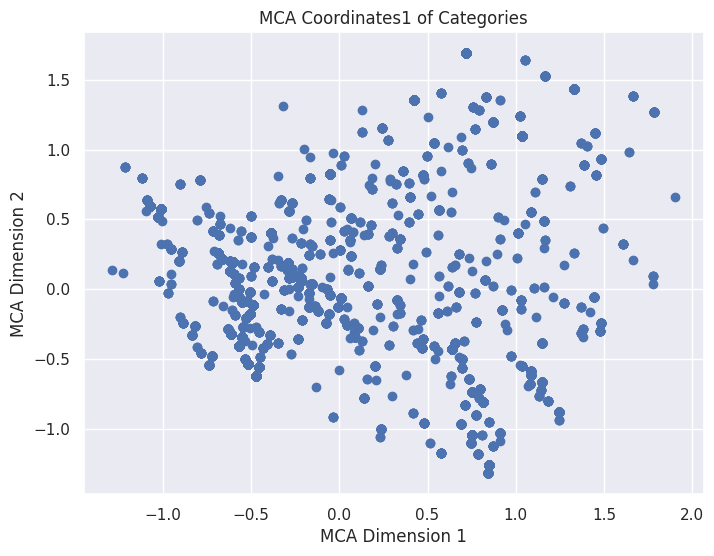

In [ ]:
# Get the MCA coordinates1 of categories
coordinates1 = mca.transform(df[mca_cols]).values
# coordinates1.head()
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(coordinates1[:, 0], coordinates1[:, 1])

# # Annotate the points with category labels (optional)
# for i, label in enumerate(df[mca_cols].index):
#     plt.annotate(label, (coordinates1[i, 0], coordinates1[i, 1]))

# Add labels and title
plt.xlabel('MCA Dimension 1')
plt.ylabel('MCA Dimension 2')
plt.title('MCA Coordinates1 of Categories')

# Show the plot
plt.show()

## Multivariate analysis with ACM

In [ ]:
!pip install fanalysis -q

In [ ]:
import fanalysis.mca as mca
# list of qualitative variables
X = df[mca_cols].values

Using the fanalysis library to perform Multiple Correspondence Analysis (MCA) on categorical data.

In [ ]:
# Create an instance of the MCA class
my_mca = mca.MCA(row_labels=df.index.values, var_labels=mca_cols)

In [ ]:
# Estimation of MCA
my_mca.fit(X)

MCA(row_labels=array([   0,    1,    2, ..., 8787, 8788, 8789]),
    var_labels=Index(['type', 'rating', 'continent', 'broad_genre'], dtype='object'))

In [ ]:
print(my_mca)

MCA(row_labels=array([   0,    1,    2, ..., 8787, 8788, 8789]),
    var_labels=Index(['type', 'rating', 'continent', 'broad_genre'], dtype='object'))


Access and visualize the eigenvalues of MCA

In [ ]:
print(my_mca.eig_)

[[4.90308866e-01 4.41728753e-01 3.54829514e-01 3.00416228e-01
  2.87473124e-01 2.76784964e-01 2.70100109e-01 2.66009492e-01
  2.57979556e-01 2.57402001e-01 2.54825371e-01 2.50000000e-01
  2.50000000e-01 2.50000000e-01 2.50000000e-01 2.50000000e-01
  2.50000000e-01 2.42829821e-01 2.38617448e-01 2.34629643e-01
  2.26607060e-01 2.20868032e-01 2.15279475e-01 2.09888789e-01
  1.88001388e-01 1.32084694e-01 7.30678216e-02 6.02678505e-02]
 [7.00441237e+00 6.31041075e+00 5.06899306e+00 4.29166040e+00
  4.10675891e+00 3.95407092e+00 3.85857298e+00 3.80013560e+00
  3.68542223e+00 3.67717145e+00 3.64036245e+00 3.57142857e+00
  3.57142857e+00 3.57142857e+00 3.57142857e+00 3.57142857e+00
  3.57142857e+00 3.46899744e+00 3.40882069e+00 3.35185204e+00
  3.23724372e+00 3.15525759e+00 3.07542107e+00 2.99841128e+00
  2.68573412e+00 1.88692420e+00 1.04382602e+00 8.60969293e-01]
 [7.00441237e+00 1.33148231e+01 1.83838162e+01 2.26754766e+01
  2.67822355e+01 3.07363064e+01 3.45948794e+01 3.83950150e+01
  4.20

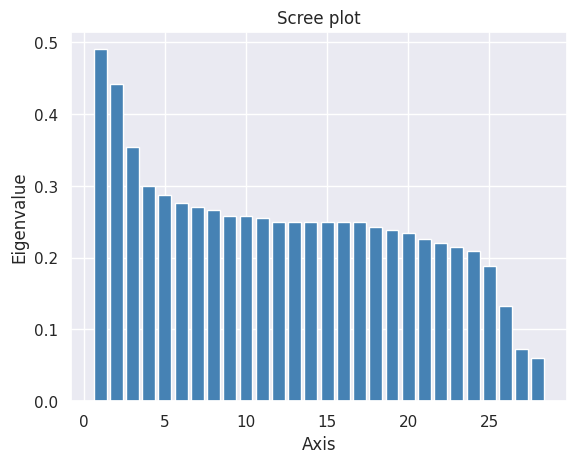

In [ ]:
my_mca.plot_eigenvalues()

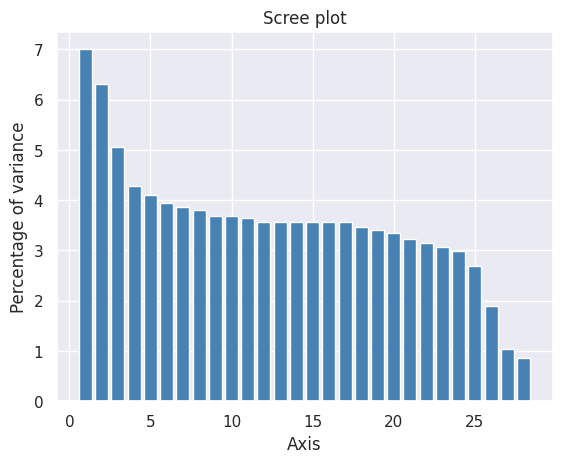

In [ ]:
# Percentage of variance explained
my_mca.plot_eigenvalues(type="percentage")

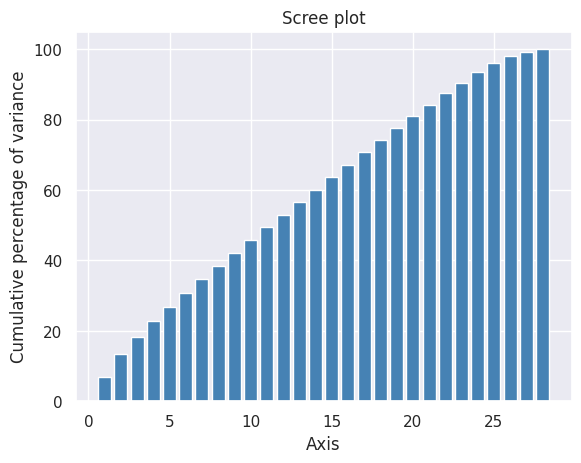

In [ ]:
# Cumulative explained variance
my_mca.plot_eigenvalues(type="cumulative")

 Conclusion: Eigenvalues represent the variance explained by each dimension (component) in the MCA. The higher the eigenvalue, the more variance is explained by that dimension. So here we can observe the first three components has extremely high eigenvalue, it means that these three components are the most important dimensions in explaining the variance in our categorical data.

Now let's plot the quality of representation (cos2 values) of the modalities (categories) of our categorical variables (columns) on the first axis (dimension) of Multiple Correspondence Analysis (MCA).

first Axe


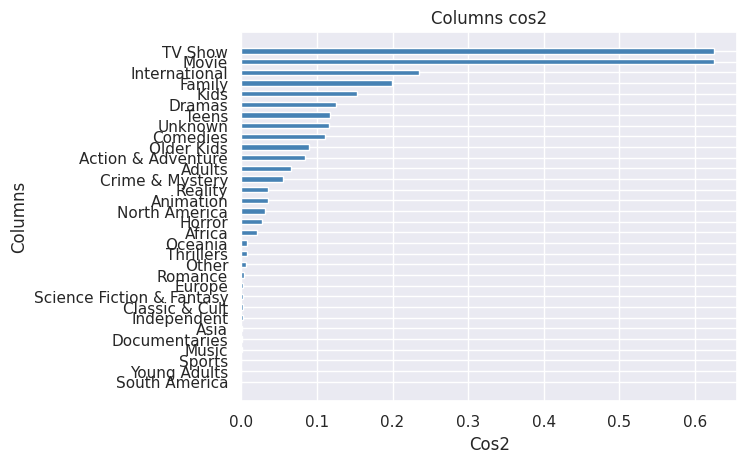

second  Axe


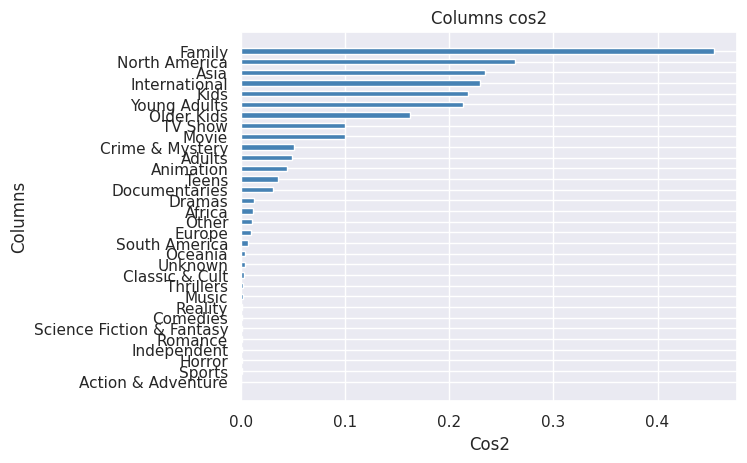

third  Axe


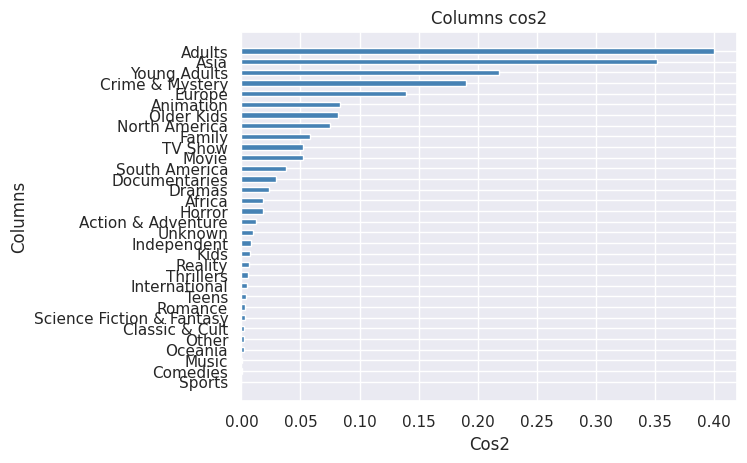

In [ ]:
print("first Axe")
my_mca.plot_col_cos2(num_axis=1)
print("second  Axe")
my_mca.plot_col_cos2(num_axis=2)
print("third  Axe")
my_mca.plot_col_cos2(num_axis=3)

Conclusion : The columns with the higer cos2 values are the better represented columns by the corresponding axis in MCA. Here we can identify TVshow and Movie have modalities that align strongly with the first axis, making them the best-represented columns by this dimension, And "Family" is the best-represented columns by the second aixs. "Adult" is the best-represented columns by the third aixs.

Make graphical representation of columns based on their positions in the MCA components space.

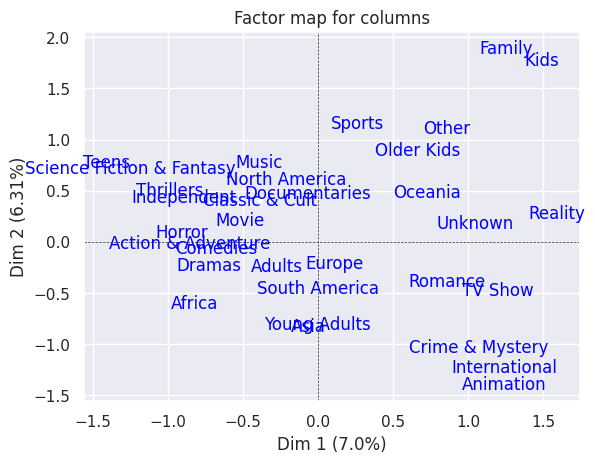

In [ ]:
# Graph of column points
my_mca.mapping_col(num_x_axis=1, num_y_axis=2)

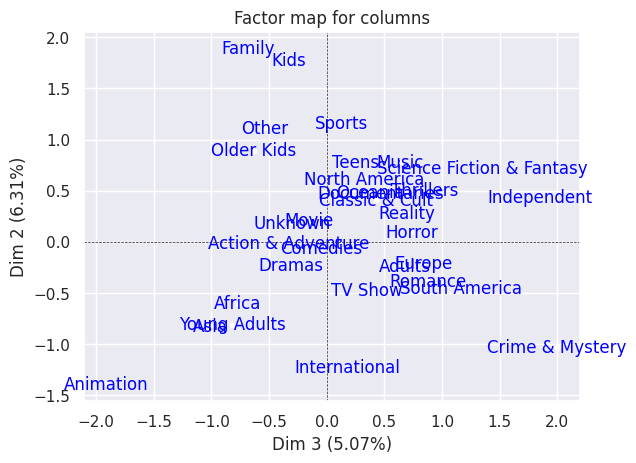

In [ ]:
# Graph of column points
my_mca.mapping_col(num_x_axis=3, num_y_axis=2)

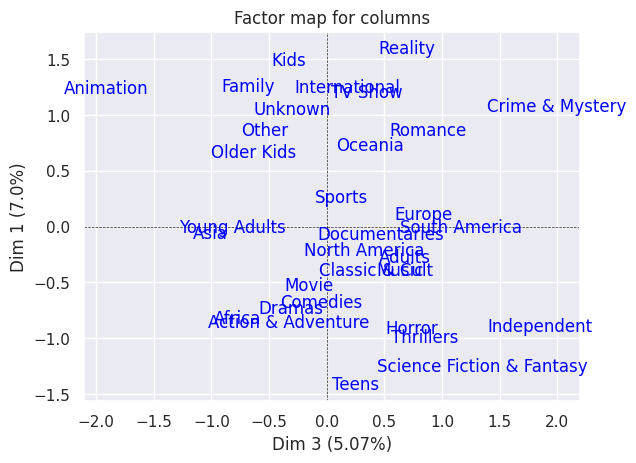

In [ ]:
# Graph of column points
my_mca.mapping_col(num_x_axis=3, num_y_axis=1)

Conclusion: 1. we observed that "family" and "kids" always have a close position, we may can say that kids always watch family type video on Netflix.

##Factorial analysis on Quantitative dataset (PCA)

In [ ]:
# Instantiate PCA class
pca = prince.PCA(n_components = 2)

# Get princical components
pca = pca.fit(df[pca_cols])

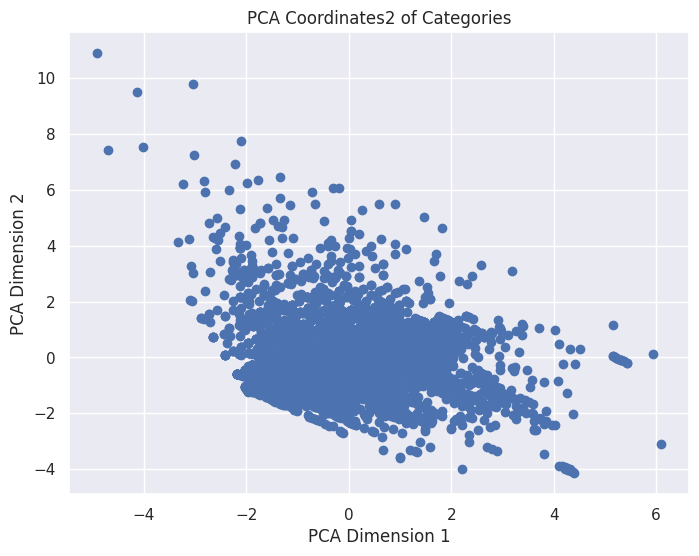

In [ ]:
# Get the PCA coordinates2 of categories
coordinates2 = pca.transform(df[pca_cols]).values
# coordinates2.head()
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(coordinates2[:, 0], coordinates2[:, 1])

# # Annotate the points with category labels (optional)
# for i, label in enumerate(df[mca_cols].index):
#     plt.annotate(label, (coordinates2[i, 0], coordinates2[i, 1]))

# Add labels and title
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('PCA Coordinates2 of Categories')

# Show the plot
plt.show()

# **Clustering**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

sns.set()

## Clustering on Qualitative dataset

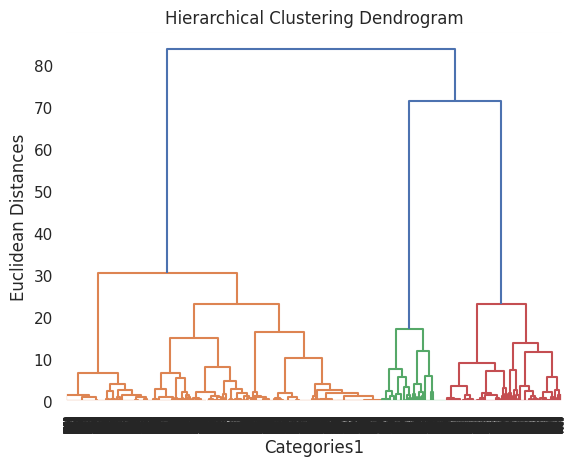

In [ ]:
# Perform hierarchical clustering
dendrogram = sch.dendrogram(sch.linkage(coordinates1, method='ward'))

# Add labels and title to the dendrogram
plt.xlabel('Categories1')
plt.ylabel('Euclidean Distances')
plt.title('Hierarchical Clustering Dendrogram')

# Show the dendrogram
plt.show()

In [ ]:
# Define the number of clusters you want to create
n_clusters = 3  # You can change this to your desired number of clusters

# Instantiate the KMeans clustering algorithm
kmeans = KMeans(n_clusters=n_clusters, random_state=40) #the random stage should be high ???

# Fit the KMeans model to the MCA-transformed data (coordinates1)
kmeans.fit(coordinates1)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Assign cluster labels to the original DataFrame
df['Cluster_Labels'] = cluster_labels

# Display the DataFrame with cluster labels
print(df.head())

    type  release_year      rating  duration  year_added  month_added  \
0  Movie          2020       Teens      90.0        2021            9   
1  Movie          2021  Older Kids      91.0        2021            9   
2  Movie          1993      Adults     125.0        2021            9   
3  Movie          2021       Teens     104.0        2021            9   
4  Movie          2021      Adults     127.0        2021            9   

       continent    broad_genre  Cluster_Labels  
0  North America  Documentaries               1  
1        Unknown         Family               2  
2  North America         Dramas               1  
3  North America       Comedies               1  
4         Europe         Dramas               1  


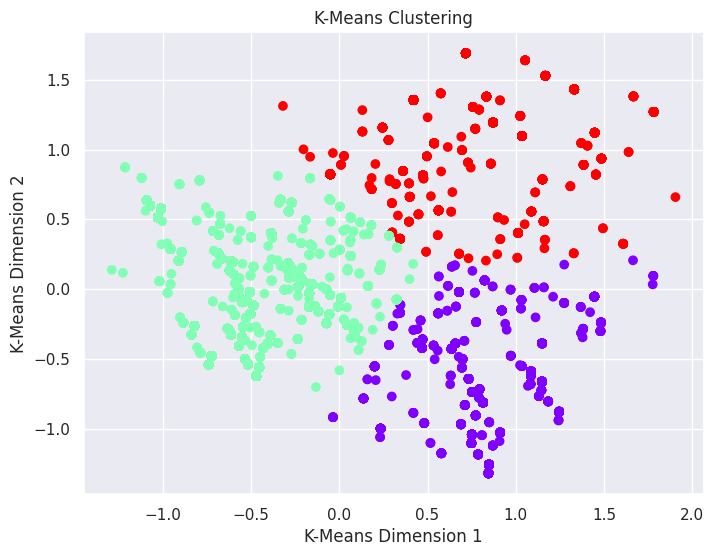

In [ ]:
# Create a scatter plot of the clustered data
plt.figure(figsize=(8, 6))
plt.scatter(coordinates1[:, 0], coordinates1[:, 1], c=cluster_labels, cmap='rainbow')

# # Annotate the points with cluster labels (optional)
# for i, label in enumerate(cluster_labels):
#     plt.annotate(label, (coordinates1[i, 0], coordinates1[i, 1]))

# Add labels and title
plt.xlabel('K-Means Dimension 1')
plt.ylabel('K-Means Dimension 2')
plt.title('K-Means Clustering')

# Show the plot
plt.show()

## Clustering on Quantitative dataSet

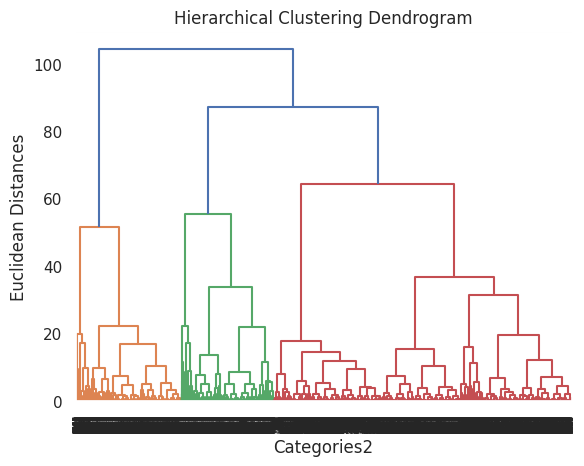

In [ ]:
# Perform hierarchical clustering
dendrogram = sch.dendrogram(sch.linkage(coordinates2, method='ward'))

# Add labels and title to the dendrogram
plt.xlabel('Categories2')
plt.ylabel('Euclidean Distances')
plt.title('Hierarchical Clustering Dendrogram')

# Show the dendrogram
plt.show()

In [ ]:
# Define the number of clusters you want to create
n_clusters = 3  # You can change this to your desired number of clusters

# Instantiate the KMeans clustering algorithm
kmeans = KMeans(n_clusters=n_clusters, random_state=40)

# Fit the KMeans model to the MCA-transformed data (coordinates2)
kmeans.fit(coordinates2)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Assign cluster labels to the original DataFrame
df['Cluster_Labels'] = cluster_labels

# Display the DataFrame with cluster labels
print(df.head())

    type  release_year      rating  duration  year_added  month_added  \
0  Movie          2020       Teens      90.0        2021            9   
1  Movie          2021  Older Kids      91.0        2021            9   
2  Movie          1993      Adults     125.0        2021            9   
3  Movie          2021       Teens     104.0        2021            9   
4  Movie          2021      Adults     127.0        2021            9   

       continent    broad_genre  Cluster_Labels  
0  North America  Documentaries               0  
1        Unknown         Family               0  
2  North America         Dramas               1  
3  North America       Comedies               0  
4         Europe         Dramas               0  


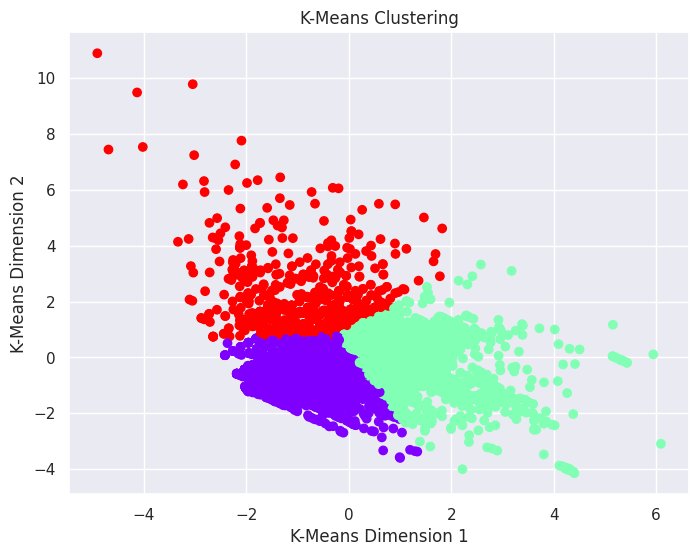

In [ ]:
# Create a scatter plot of the clustered data
plt.figure(figsize=(8, 6))
plt.scatter(coordinates2[:, 0], coordinates2[:, 1], c=cluster_labels, cmap='rainbow')

# # Annotate the points with cluster labels (optional)
# for i, label in enumerate(cluster_labels):
#     plt.annotate(label, (coordinates2[i, 0], coordinates2[i, 1]))

# Add labels and title
plt.xlabel('K-Means Dimension 1')
plt.ylabel('K-Means Dimension 2')
plt.title('K-Means Clustering')

# Show the plot
plt.show()

# Here, we created new dataset where all the qualitative colums have been extended (we will see if this can be used to deepen our studies)

one-hot-encoding on the type columns

In [ ]:
# Extract information from the 'type' column
# Split the 'type' column into separate columns
netflix_categories = data['type'].str.get_dummies()
    #print(netflix_categories)

# Extract unique categories or genres
categories = netflix_categories.columns
  ##print(categories)

# Create a new DataFrame with the 'release_year' and 'duration' columns
category_df = pd.DataFrame({'release_year': data['release_year'], 'duration': data['duration']})

# Iterate through the unique categories and create a new column for each one, setting the values to 1 or 0 based on whether the category is present in the 'type' column for each row:
for category in categories:
    category_df[category] = data['type'].str.contains(category).astype(int).copy()

category_df.head()

,release_year,duration,Movie,TV Show
0,2020,90.0,1,0
1,2021,91.0,1,0
2,1993,125.0,1,0
3,2021,104.0,1,0
4,2021,127.0,1,0


one-hot-encoding on the rating columns



In [ ]:
# Extract information from the 'rating' column
# Split the 'rating' column into separate columns
netflix_categories = data['rating'].str.get_dummies()
    #print(netflix_categories)

# Extract unique categories or genres
categories = netflix_categories.columns
  ##print(categories)

# Iterate through the unique categories and create a new column for each one, setting the values to 1 or 0 based on whether the category is present in the 'rating' column for each row:
for category in categories:
    category_df[category] = data['rating'].str.contains(category).astype(int).copy()

category_df.head()

,release_year,duration,Movie,TV Show,Adults,Kids,Older Kids,Teens,Young Adults
0,2020,90.0,1,0,0,0,0,1,0
1,2021,91.0,1,0,0,1,1,0,0
2,1993,125.0,1,0,1,0,0,0,0
3,2021,104.0,1,0,0,0,0,1,0
4,2021,127.0,1,0,1,0,0,0,0


one-hot-encoding on the continent columns

In [ ]:
# Extract information from the 'continent' column
# Split the 'continent' column into separate columns
netflix_categories = data['continent'].str.get_dummies()
    #print(netflix_categories)

# Extract unique categories or genres
categories = netflix_categories.columns
  ##print(categories)

# Iterate through the unique categories and create a new column for each one, setting the values to 1 or 0 based on whether the category is present in the 'continent' column for each row:
for category in categories:
    category_df[category] = data['continent'].str.contains(category).astype(int).copy()

category_df.head()

,release_year,duration,Movie,TV Show,Adults,Kids,Older Kids,Teens,Young Adults,Africa,Asia,Europe,North America,Oceania,South America,Unknown
0,2020,90.0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,2021,91.0,1,0,0,1,1,0,0,0,0,0,0,0,0,1
2,1993,125.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
3,2021,104.0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
4,2021,127.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0


one-hot-encoding on the broad_genre columns

In [ ]:
# Extract information from the 'broad_genre' column
# Split the 'broad_genre' column into separate columns
netflix_categories = data['broad_genre'].str.get_dummies()
    #print(netflix_categories)

# Extract unique categories or genres
categories = netflix_categories.columns
  ##print(categories)

# Iterate through the unique categories and create a new column for each one, setting the values to 1 or 0 based on whether the category is present in the 'broad_genre' column for each row:
for category in categories:
    category_df[category] = data['broad_genre'].str.contains(category).astype(int).copy()

category_df.head()

,release_year,duration,Movie,TV Show,Adults,Kids,Older Kids,Teens,Young Adults,Africa,...,Horror,Independent,International,Music,Other,Reality,Romance,Science Fiction & Fantasy,Sports,Thrillers
0,2020,90.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021,91.0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1993,125.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021,104.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021,127.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
## for the rest of the exercice
data= category_df